# SVM (Assignment 5)

## Student: Rodolfo Lerma

In this assignment, you will implement a Support Vector Machine Classifier  from scratch and compare the results to existing sklearn algorithm. 

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# make this notebook's output stable across runs
np.random.seed(0)

## Data Exploration

In [2]:
df = pd.read_csv('data_banknote_authentication.csv', header = None)

In [3]:
df.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
df.shape

(1372, 5)

The dataset has 5 features and 1372 rows.

In [5]:
df.dtypes

0    float64
1    float64
2    float64
3    float64
4      int64
dtype: object

In [6]:
df.isnull().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

There are no missing values in the dataset.


4 input features are numeric and the target variable is binary.

In [7]:
df.describe()

,0,1,2,3,4
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [8]:
features = df.columns.to_list()
features.remove(4)

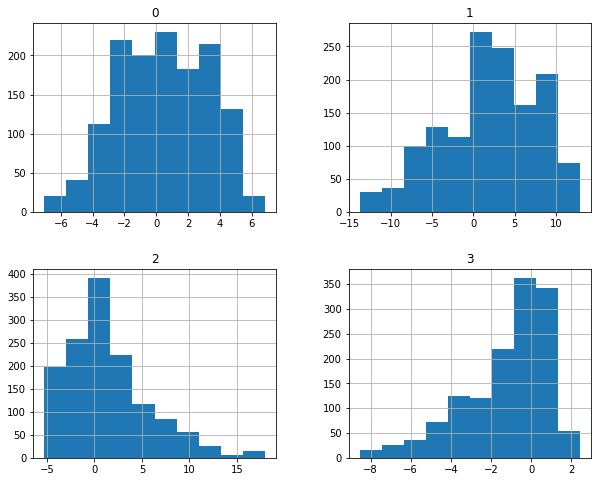

In [9]:
df[features].hist(figsize = (10,8))
plt.show()

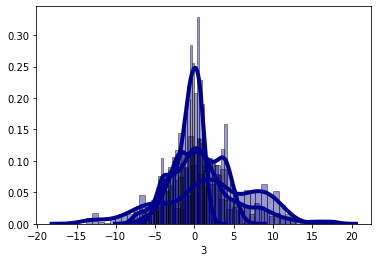

In [10]:
# Density Plot and Histogram of all arrival delays
import seaborn as sns

for i in features: 
    sns.distplot(df[i], hist=True, kde=True, 
                 bins=int(180/5), color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

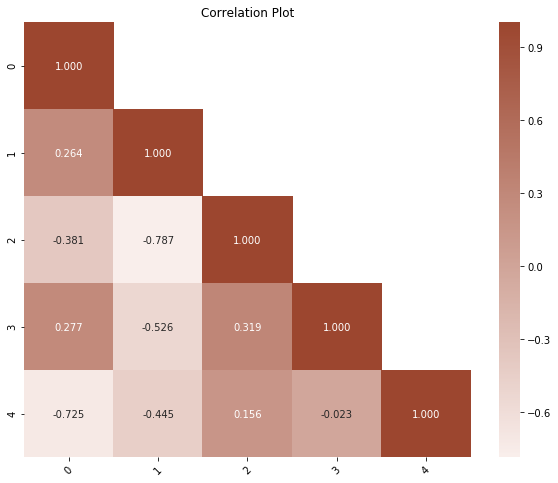

In [11]:
corr = df.corr()
hm_fig, hm_ax = plt.subplots(figsize=(10,8))
mask = np.logical_not(np.tril(np.ones_like(corr, dtype=np.bool)))
sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    fmt='.3f',
    ax=hm_ax,
    cmap=sns.light_palette('#9c462f', n_colors=300),
)
hm_ax.set_xticklabels(hm_ax.get_xticklabels(), rotation=45)
hm_ax.set_title('Correlation Plot')
hm_ax.patch.set_alpha(0);

It is possible to notice the high negative correlation between the feature `0` and the target variable.

### Target Variable

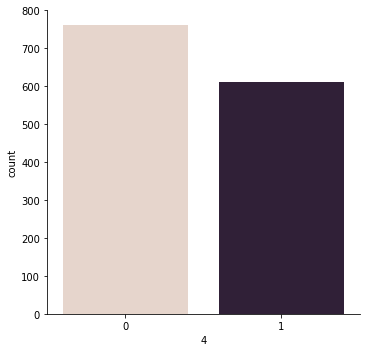

In [12]:
import seaborn as sns
sns.catplot(x=4, kind="count", palette="ch:.1", data=df)

We can see that the target feature has to variables and both are comparable in terms of their presence in the dataset. (No noticeable Class Imbalance is present in the data).

### Comparison Scatterplots

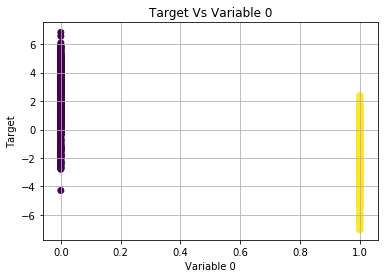

In [13]:
plt.scatter(x=df[4], y=df[0], c=df[4])
plt.title("Target Vs Variable 0")
plt.xlabel("Variable 0")
plt.ylabel("Target")
plt.grid(True)
plt.show()

As it was noticed before, `Variable 0` is the one that offers the highest correlation with the `Feature` variable.

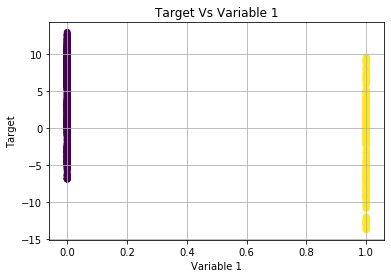

In [14]:
plt.scatter(x=df[4], y=df[1], c=df[4])
plt.title("Target Vs Variable 1")
plt.xlabel("Variable 1")
plt.ylabel("Target")
plt.grid(True)
plt.show()

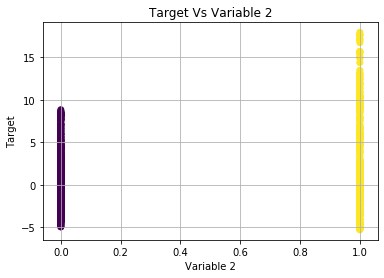

In [15]:
plt.scatter(x=df[4], y=df[2], c=df[4])
plt.title("Target Vs Variable 2")
plt.xlabel("Variable 2")
plt.ylabel("Target")
plt.grid(True)
plt.show()

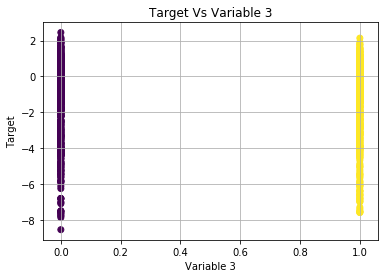

In [16]:
plt.scatter(x=df[4], y=df[3], c=df[4])
plt.title("Target Vs Variable 3")
plt.xlabel("Variable 3")
plt.ylabel("Target")
plt.grid(True)
plt.show()

The `Variable 3` appers to be uncorrelated to the `Feature` Variable.

## Question 1.1: Implement the cost function cost/objective function:
<img src="https://miro.medium.com/max/688/1*JAS6rUTO7TDlrv4XZSMbsA.png" alt="drawing" width="600"/>


In [17]:
def compute_cost(W, X, Y, reg_strength=1000):
    total_num = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0
    
    #Calcule the Hinge Loss
    hinge_loss = reg_strength * np.sum(distances) / total_num
    
    #Cost Function
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    
    return cost

## Question 1.2: Write a method that calculate the cost gradient:
<img src="https://miro.medium.com/max/866/1*ww3F21VMVGp2NKhm0VTesA.png" alt="drawing" width="600"/>

In [18]:
def calculate_cost_gradient(W, X_batch, Y_batch, reg_strength=1000):
    
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))
    
    print(X_batch.shape)
    print(Y_batch.shape)
    print('*')
    print(distance)
    print(distance.shape)
    
    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (reg_strength * Y_batch[ind] *  X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)
    
    return dw

## Question 1.3: Write a method that performs stochastic Gradient descent as follows:
- Caluclate the gradient of cost function i.e. ∇J(w)
- Update the weights in the opposite direction to the gradient: w = w — ∝(∇J(w))
- Repeat until conversion or until 5000 epochs are reached

In [19]:
def sgd(data, outputs, learning_rate = 0.0001, max_epochs = 5000):
    
    weights = np.zeros(data.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(data, outputs)
        
        for ind, x in enumerate(X):#TO DO
            Z = Y[ind]
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent) 
            
        # convergence check on 2^nth epoch
            if epoch == 2 ** nth or epoch == max_epochs - 1:
                cost = compute_cost(weights, data, outputs)
                print("Epoch is :{} and Cost is : {}".format(epoch, cost))

                # stoppage criterion
                if abs(prev_cost - cost) < cost_threshold * prev_cost:
                    return weights

                prev_cost = cost
                nth += 1
               
    return weights

# Dataset

In [20]:
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('data_banknote_authentication.csv', header = None)

Y = data.iloc[:, 4]
X = data.iloc[:, 0:4]

X_normalized = MinMaxScaler().fit_transform(X.values)
X = pd.DataFrame(X_normalized)

X.insert(loc=len(X.columns), column='intercept', value=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [21]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: 4, dtype: int64

In [22]:
X.head()

,0,1,2,3,intercept
0,0.769004,0.839643,0.106783,0.736628,1
1,0.835659,0.820982,0.121804,0.644326,1
2,0.786629,0.416648,0.310608,0.786951,1
3,0.757105,0.871699,0.054921,0.450440,1
4,0.531578,0.348662,0.424662,0.687362,1


In [23]:
X.shape

(1372, 5)

## Question 4: Train and evaluate an SVC using the banknote_authentication data

In [24]:
# train the model
print("training started...")
W = sgd(X_train.to_numpy(), y_train.to_numpy())
print("training finished.")
print("weights are: {}".format(W))

training started...
(5,)
()
*
1.0
()


TypeError: 'numpy.float64' object is not iterable

In [ ]:
# testing the model on test set
y_test_predicted = np.array([])
for i in range(X_test.shape[0]):
    yp = np.sign(np.dot(W, X_test.to_numpy()[i]))
    y_test_predicted = np.append(y_test_predicted, yp)

predictions = []
for i in range(len(y_test_predicted)):
    if y_test_predicted[i] == -1:
        z = 1
    else:
        z = 0
    predictions.append(z)
    
print("accuracy on test dataset: {}".format(accuracy_score(y_test.to_numpy(), predictions)))
#print("recall on test dataset: {}".format(recall_score(y_test.to_numpy(), y_test_predicted)))
#print("precision on test dataset: {}".format(precision_score(y_test.to_numpy(), y_test_predicted)))

## [Bonus] Question 5: Train and evaluate an SKLEARN SVC model, and compare the results to your model. [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [ ]:
from sklearn.svm import SVC

In [ ]:
X_svm = df[features]
y_svm = df[4]

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

In [ ]:
y_svm.head()

In [ ]:
X_svm.head()

### Hyperparameters 

In [ ]:
parameters = {"C": [0, 0.2, 0.4, 0.6, 0.8, 1.0],
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "probability": [True]}

svm_base = SVC()

svm_grid = GridSearchCV(estimator = svm_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)
svm_grid.fit(X_train_svm, y_train_svm)

#### Best Hyperparameters

In [ ]:
best_params = svm_grid.best_params_
best_params

### Performance in Test Data

In [ ]:
# make predictions with the trained random forest
test_svm = svm_grid.predict(X_test_svm)
test_svm_prob = svm_grid.predict_proba(X_test_svm)

In [ ]:
def performance_values(X_test, y_test, trained_model):
    
    from sklearn import preprocessing, metrics
    from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score
    
    y_pred = trained_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    probs = trained_model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.roc_auc_score(y_test, preds)
    
    return (fpr, tpr, accuracy, recall, precision, roc_auc)

In [ ]:
def ROC_curve(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
fpr, tpr, svm_acc, svm_rec, svm_prec, svm_auc = performance_values(X_test_svm, y_test_svm, svm_grid)
print("Accuracy: {}".format(svm_acc))
print("Recall: {}".format(svm_rec))
print("Precision: {}".format(svm_prec))
print("AUC: {}".format(svm_auc))

In [ ]:
ROC_curve(fpr,tpr,svm_auc)

### Comparison on Model with less features

There are some features that have a very low correlation value, in this section I will explore the impact on removing such variables.

The variables to be remove are `Variable 2` & `Variable 3`. Based on the correlation value (seen above) these features  does not provide much value to the prediction of the `Target` Variable.

In [ ]:
#Training & Testing Dataset
X_svm = df[[0,1]]
y_svm = df[4]
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.2, random_state=42)

#Hyperparameters
parameters = {"C": [0, 0.2, 0.4, 0.6, 0.8, 1.2, 1.4, 2],
              "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
              "probability": [True]}
svm_base = SVC()
svm_grid = GridSearchCV(estimator = svm_base, param_grid = parameters,
                        cv = 10, verbose = 2, n_jobs = -1)

#Training the Model
svm_grid.fit(X_train_svm, y_train_svm)

#Hyperparameters Best Parameters
best_params = svm_grid.best_params_
print("Best Hyperparameters: {}".format(best_params))

#Performance on Testing Data
fpr, tpr, svm_acc, svm_rec, svm_prec, svm_auc = performance_values(X_test_svm, y_test_svm, svm_grid)
print("Accuracy: {}".format(svm_acc))
print("Recall: {}".format(svm_rec))
print("Precision: {}".format(svm_prec))
print("AUC: {}".format(svm_auc))
ROC_curve(fpr,tpr,svm_auc)

It is possible to notice that the performance drop a little bit, but at the same time these values might be showing us that the previous model was overfitting the data.

## Question 7: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: 
- What was your incoming experience with this model, if any? 
- What steps you took, what obstacles you encountered?
- How you link this exercise to real-world, machine learning problem-solving. 
- What steps were missing? What else do you need to learn?

In [ ]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split as tts
# from sklearn.metrics import accuracy_score, recall_score, precision_score
# from sklearn.utils import shuffle


# # >> FEATURE SELECTION << #
# def remove_correlated_features(X):
#     corr_threshold = 0.9
#     corr = X.corr()
#     drop_columns = np.full(corr.shape[0], False, dtype=bool)
#     for i in range(corr.shape[0]):
#         for j in range(i + 1, corr.shape[0]):
#             if corr.iloc[i, j] >= corr_threshold:
#                 drop_columns[j] = True
#     columns_dropped = X.columns[drop_columns]
#     X.drop(columns_dropped, axis=1, inplace=True)
#     return columns_dropped


# def remove_less_significant_features(X, Y):
#     sl = 0.05
#     regression_ols = None
#     columns_dropped = np.array([])
#     for itr in range(0, len(X.columns)):
#         regression_ols = sm.OLS(Y, X).fit()
#         max_col = regression_ols.pvalues.idxmax()
#         max_val = regression_ols.pvalues.max()
#         if max_val > sl:
#             X.drop(max_col, axis='columns', inplace=True)
#             columns_dropped = np.append(columns_dropped, [max_col])
#         else:
#             break
#     regression_ols.summary()
#     return columns_dropped


# ##############################


# # >> MODEL TRAINING << #
# def compute_cost(W, X, Y):
#     # calculate hinge loss
#     N = X.shape[0]
#     distances = 1 - Y * (np.dot(X, W))
#     distances[distances < 0] = 0  # equivalent to max(0, distance)
#     hinge_loss = regularization_strength * (np.sum(distances) / N)

#     # calculate cost
#     cost = 1 / 2 * np.dot(W, W) + hinge_loss
#     return cost


# # I haven't tested it but this same function should work for
# # vanilla and mini-batch gradient descent as well
# def calculate_cost_gradient(W, X_batch, Y_batch):
#     # if only one example is passed (eg. in case of SGD)
#     if type(Y_batch) == np.float64:
#         Y_batch = np.array([Y_batch])
#         X_batch = np.array([X_batch])  # gives multidimensional array

#     distance = 1 - (Y_batch * np.dot(X_batch, W))
#     dw = np.zeros(len(W))

#     for ind, d in enumerate(distance):
#         if max(0, d) == 0:
#             di = W
#         else:
#             di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
#         dw += di

#     dw = dw/len(Y_batch)  # average
#     return dw


# def sgd(features, outputs):
#     max_epochs = 5000
#     weights = np.zeros(features.shape[1])
#     nth = 0
#     prev_cost = float("inf")
#     cost_threshold = 0.01  # in percent
#     # stochastic gradient descent
#     for epoch in range(1, max_epochs):
#         # shuffle to prevent repeating update cycles
#         X, Y = shuffle(features, outputs)
#         for ind, x in enumerate(X):
#             ascent = calculate_cost_gradient(weights, x, Y[ind])
#             weights = weights - (learning_rate * ascent)

#         # convergence check on 2^nth epoch
#         if epoch == 2 ** nth or epoch == max_epochs - 1:
#             cost = compute_cost(weights, features, outputs)
#             print("Epoch is: {} and Cost is: {}".format(epoch, cost))
#             # stoppage criterion
#             if abs(prev_cost - cost) < cost_threshold * prev_cost:
#                 return weights
#             prev_cost = cost
#             nth += 1
#     return weights


# ########################


# def init():
#     print("reading dataset...")
#     # read data in pandas (pd) data frame
#     data = pd.read_csv('./data/data.csv')

#     # drop last column (extra column added by pd)
#     # and unnecessary first column (id)
#     data.drop(data.columns[[-1, 0]], axis=1, inplace=True)

#     print("applying feature engineering...")
#     # convert categorical labels to numbers
#     diag_map = {'M': 1.0, 'B': -1.0}
#     data['diagnosis'] = data['diagnosis'].map(diag_map)

#     # put features & outputs in different data frames
#     Y = data.loc[:, 'diagnosis']
#     X = data.iloc[:, 1:]

#     # filter features
#     remove_correlated_features(X)
#     remove_less_significant_features(X, Y)

#     # normalize data for better convergence and to prevent overflow
#     X_normalized = MinMaxScaler().fit_transform(X.values)
#     X = pd.DataFrame(X_normalized)

#     # insert 1 in every row for intercept b
#     X.insert(loc=len(X.columns), column='intercept', value=1)

#     # split data into train and test set
#     print("splitting dataset into train and test sets...")
#     X_train, X_test, y_train, y_test = tts(X, Y, test_size=0.2, random_state=42)

#     # train the model
#     print("training started...")
#     W = sgd(X_train.to_numpy(), y_train.to_numpy())
#     print("training finished.")
#     print("weights are: {}".format(W))

#     # testing the model
#     print("testing the model...")
#     y_train_predicted = np.array([])
#     for i in range(X_train.shape[0]):
#         yp = np.sign(np.dot(X_train.to_numpy()[i], W))
#         y_train_predicted = np.append(y_train_predicted, yp)

#     y_test_predicted = np.array([])
#     for i in range(X_test.shape[0]):
#         yp = np.sign(np.dot(X_test.to_numpy()[i], W))
#         y_test_predicted = np.append(y_test_predicted, yp)

#     print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))
#     print("recall on test dataset: {}".format(recall_score(y_test, y_test_predicted)))
#     print("precision on test dataset: {}".format(recall_score(y_test, y_test_predicted)))


# # set hyper-parameters and call init
# regularization_strength = 10000
# learning_rate = 0.000001
# init()

[Example](https://towardsdatascience.com/svm-implementation-from-scratch-python-2db2fc52e5c2#72a3)